<a href="https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7/blob/main/Baseline_Tweet_Sentiment_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/hoanglam372000/Applied-Data-Science-Group-7.git

In [ ]:
!pip install emoji

In [ ]:

import pandas as pd
import nltk
import numpy as np
import emoji
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


False

In [ ]:
df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')

In [ ]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


# Tách tập dữ liệu

In [ ]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 70%:30%
X_df = df.drop(labels = 'selected_text',axis = 1)
y_ex = df.selected_text
y_class = df.sentiment
train_X_df, val_X_df, train_y_ex, val_y_ex = train_test_split(X_df, y_ex, test_size=0.3, 
                                                              stratify=y_class, random_state=0)

In [ ]:
print('train_X: ',train_X_df.shape)
print('train_y: ',train_y_ex.shape)
print('val_X: ',val_X_df.shape)
print('val_y: ',val_y_ex.shape)


train_X:  (19236, 3)
train_y:  (19236,)
val_X:  (8244, 3)
val_y:  (8244,)


# Tiền xử lý + Khám phá tập train

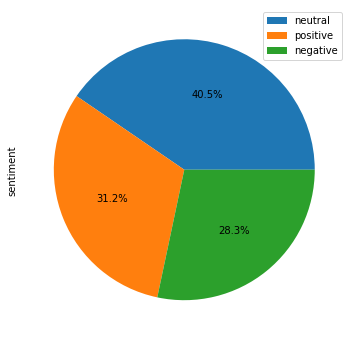

In [ ]:
#Phân bố của các lớp:
train_X_df.sentiment.value_counts(normalize= True).plot(kind="pie",labels = None, legend='auto', figsize=(8,6), autopct="%.1f%%");

In [ ]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19236 entries, 652 to 12238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     19236 non-null  object
 1   text       19236 non-null  object
 2   sentiment  19236 non-null  object
dtypes: object(3)
memory usage: 601.1+ KB


In [ ]:
train_X_df.duplicated().sum()

0

In [ ]:
train_y_ex.isnull().sum()

0

# Tiền xử lý text

In [ ]:
def preprocessing(tweet):
    '''
    input: a tweet (str)
    output: a list of words (list)
    '''
    tweet = str(tweet).strip()
    new_tweet = tweet.split()
    index2word = { w:new_tweet[w] for w in range(len(new_tweet))}
    #word2index = { new_tweet[w]:w for w in range(len(new_tweet))} # Biễu diễn mỗi từ là 1 index để sau này phục hồi
    #print('origin: ',word2index)
    preprocess_tweet = dict({i[0]:i[1].lower()  for i in index2word.items()})
    #preprocess_tweet = {re.sub(r'i[`\'"][\w]+', 'i',w[0]):w[1] for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'https?:\/\/.*[\r\n]*', '<URL>',w[1]) for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'\*+', '<HIDDEN>',w[1]) for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'@\w+', '<tag>',w[1]) for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'@\w+', '<tag>',w[1]) for w in preprocess_tweet.items()}
    preprocessed_tweet = {}
    for w in preprocess_tweet.items():
      if emoji.get_emoji_regexp().search(w[1]) or w[1].isalpha() or w[1]=='<URL>':
        preprocessed_tweet[w[0]] = w[1]
      elif w[1].isdigit():
        preprocessed_tweet[w[0]] = w[1].replace(w[1],'<NUMBER>')
      
      else:
        
          r = re.sub(r"[#!\"$%&\'*+,-\.?@\[\]`{|}]*",'',w[1])
          preprocessed_tweet[w[0]] = r
    stemmer = PorterStemmer()
    preprocessed_tweet = {w[0]:stemmer.stem(w[1]) for w in preprocessed_tweet.items()}
    return index2word,preprocessed_tweet
    

    
    #new_tweets = [str(tweet).split(" ") for tweet in tweets]
    
    #for tweet in new_tweets:
    #    if "" in tweet:
    #        tweet.pop(tweet.index(""))
    #return new_tweets

In [ ]:
tweet = ' My mom just texted me and told me that Rodney was *** chasing?? and fireflies... in their :)) backyard. Awwwww I`m miss him!!! @hoanglam 123 ://    http://twitpic.com/66pn1'
tweet2 = 'their :)) <3'
index2word_temp,preprocessed_tweet_temp = preprocessing(tweet)

In [ ]:
print('index2word: ',index2word_temp)
print('preprocessed_tweet: ',preprocessed_tweet_temp)

index2word:  {0: 'My', 1: 'mom', 2: 'just', 3: 'texted', 4: 'me', 5: 'and', 6: 'told', 7: 'me', 8: 'that', 9: 'Rodney', 10: 'was', 11: '***', 12: 'chasing??', 13: 'and', 14: 'fireflies...', 15: 'in', 16: 'their', 17: ':))', 18: 'backyard.', 19: 'Awwwww', 20: 'I`m', 21: 'miss', 22: 'him!!!', 23: '@hoanglam', 24: '123', 25: '://', 26: 'http://twitpic.com/66pn1'}
preprocessed_tweet:  {0: 'my', 1: 'mom', 2: 'just', 3: 'text', 4: 'me', 5: 'and', 6: 'told', 7: 'me', 8: 'that', 9: 'rodney', 10: 'wa', 11: '<hidden>', 12: 'chase', 13: 'and', 14: 'firefli', 15: 'in', 16: 'their', 17: ':))', 18: 'backyard', 19: 'awwwww', 20: 'im', 21: 'miss', 22: 'him', 23: '<tag>', 24: '<number>', 25: '://', 26: '<url>'}


In [ ]:
def preprocess_tweets(X_df):
  X_df = X_df.copy()
  raw_tweets = X_df.text.to_list()
  X_df.sentiment = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1}).to_list()
  index2word_tweets = [] #list of dictionaries
  preprocessed_tweets = [] #list of dictionaries
  for tweet in raw_tweets:
    index2word, preprocessed = preprocessing(tweet)
    index2word_tweets.append(index2word)
    preprocessed_tweets.append(preprocessed)
  
  preprocessed_X_df = pd.DataFrame(data={'textID':X_df.textID,'index2word':index2word_tweets, 'preprocessed_texts':preprocessed_tweets,'sentiment':X_df.sentiment})
  return preprocessed_X_df



In [ ]:

def count_tweets(preprocessed_X):
    '''
    Input:
      
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    preprocessed_X = preprocessed_X.copy()
    y_s = preprocessed_X.sentiment.to_list()
    preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
    processed_tweets = [list(text.values()) for text in preprocessed_tweets ]
    result = {}

    for y, tweet in zip(y_s, processed_tweets):
        for word in tweet:
            # define the key, which is the word and label tuple
            pair = (word,y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
    ### END CODE HERE ###

    return result

In [ ]:

def naive_bayes(freqs,preprocessed_X ):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    likelihood = {}
    #prior = {}
    preprocessed_X = preprocessed_X.copy()
    train_y = preprocessed_X.sentiment.to_list()
    preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
    train_x = [list(text.values()) for text in preprocessed_tweets ]


    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = N_neu = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] ==1:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]
        elif pair[1] ==0:
            N_neu +=freqs[pair]
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents 
    # D_pos = D_c['positive']

    # # Calculate D_neg, the number of negative documents
    # D_neg = D_c['negative']
    
    # D_neu = D_c['neutral']

    # Calculate logprior
    #logprior = np.log(D_pos) - np.log(D_neg)
    # prior['neg'] = np.log(D_neg / D)
    # prior['neu'] = np.log(D_neu / D)
    # prior['pos'] = np.log(D_pos / D)
    
    
    
    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word,1),0)
        freq_neu = freqs.get((word,0),0)
        freq_neg = freqs.get((word,-1),0)
        

        # calculate the probability that each word is positive, and negative , neutral
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neu = (freq_neu + 1) / (N_neu + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        likelihood[word] = [np.log(p_w_neg),np.log(p_w_neu),np.log(p_w_pos)] 

    ### END CODE HERE ###

    return likelihood


# Hàm Training:

In [ ]:
def Training_Extracted_Sentiment(train_X_df,train_y_ex):
  preprocessed_train_X= preprocess_tweets(train_X_df)
  freqs_tw = count_tweets(preprocessed_train_X)
  likelihood = naive_bayes(freqs_tw,preprocessed_train_X)
  return preprocessed_train_X,freqs_tw,likelihood

In [ ]:
preprocessed_train_X,freqs_tw,likelihood = Training_Extracted_Sentiment(train_X_df,train_y_ex)

In [ ]:
preprocessed_train_X.head(3)

,textID,index2word,preprocessed_texts,sentiment
652,a834cef9c6,"{0: '1st', 1: 'presentation', 2: 'for', 3: 'senior', 4: 'boards?', 5: 'FML'}","{0: '1st', 1: 'present', 2: 'for', 3: 'senior', 4: 'board', 5: 'fml'}",-1
24883,5bfad683d5,"{0: 'yummy', 1: 'curry', 2: 'save', 3: 'me', 4: 'some', 5: 'please', 6: 'lol'}","{0: 'yummi', 1: 'curri', 2: 'save', 3: 'me', 4: 'some', 5: 'pleas', 6: 'lol'}",1
15385,08a8d660b1,"{0: 'I', 1: 'wish', 2: 'I', 3: 'knew', 4: 'someone', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up.', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'once', 17: 'that...","{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someon', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'onc', 17: 'that', ...",-1


In [ ]:
def Extract_Sentiment_Tweet(y,tweet,likelihood):
    '''input:
        tweet: list of word'''
    selected_tweet = []
    s = y +1
    for word in tweet:
      if likelihood.get(word,0)!=0:
            if max(likelihood[word]) == likelihood[word][s] and abs((abs(max(likelihood[word])) - abs(min(likelihood[word]))))>0.2:
                max(likelihood[word]) 
                selected_tweet.append(word)
                
    return selected_tweet

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
def Predict_Extract_text(Preprocessed_X,likelihood):
    selected = []
    preprocessed_X = Preprocessed_X.copy()
    y_s = preprocessed_X.sentiment.to_list()
    preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
    tweets = [list(text.values()) for text in preprocessed_tweets ]
    for y, tweet in zip(y_s,tweets):
        selected_predict = Extract_Sentiment_Tweet(y,tweet,likelihood)
        selected.append(selected_predict)
    return selected

In [ ]:
Predict_Extract_text(preprocessed_train_X,likelihood)[0:5]

[['senior', 'fml'],
 ['yummi', 'curri', 'save', 'pleas'],
 ['i', 'i', 'someon', 'down', 'hook', 'told', 'me', 'that', 'crappi', 'seat'],
 ['u', 'in', 'rain'],
 ['into']]

In [ ]:
def Map_Extracted(Preprocessed_X,likelihood):
  extracted_text = Predict_Extract_text(Preprocessed_X,likelihood)
  index2word = Preprocessed_X.index2word.to_list()
  preprocessed_texts = Preprocessed_X.preprocessed_texts.to_list()
  Selected_text = []
  for e,i,p in zip(extracted_text,index2word,preprocessed_texts):
    Text = {}
    for j in p.items():
      for w in e:
        if w == j[1]:
          Text[j[0]] = i[j[0]]
          
    Selected_text.append(" ".join(list(Text.values())))

  return Selected_text

In [ ]:
Map_Extracted(preprocessed_train_X,likelihood)[0:5]

['senior FML',
 'yummy curry save please',
 'I I someone down hook told me that crappy seats',
 'u in rain...',
 'into']

In [ ]:
def Score_Predict_Extract(Preprocessed_X,likelihood,y_ex):
    score = 0
    predict_selected = Map_Extracted(Preprocessed_X,likelihood)
    y_true_s = y_ex.copy().to_list()
    for y_pred, y_true in zip(predict_selected,y_true_s):
        score += jaccard(str(y_true),y_pred)
    return score/len(y_true_s)
    

In [ ]:
score = Score_Predict_Extract(preprocessed_train_X,likelihood,train_y_ex)
score

0.3569733820782971

In [ ]:
preprocessed_val_X = preprocess_tweets(val_X_df)

In [ ]:
score_val = Score_Predict_Extract(preprocessed_val_X,likelihood,val_y_ex)
score_val

0.32215676153662715

In [ ]:
preprocessed_full_X,freqs_tw_full,likelihood_full = Training_Extracted_Sentiment(X_df,y_ex)

In [ ]:
score_full = Score_Predict_Extract(preprocessed_full_X,likelihood_full,y_ex)
score_full

0.34474342725456364

In [ ]:
# predict = pd.DataFrame(data ={'textID': df.textID,'selected_text':pd.Series(extracted_text)})
# predict

In [ ]:
test_df = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
test_df

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep but i try it",negative
3530,416863ce47,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",positive
3531,6332da480c,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,negative
3532,df1baec676,_sutra what is your next youtube video gonna be about? I love your videos!,positive


In [ ]:
test_preprocessed = preprocess_tweets(test_df)

In [ ]:
preds_extracted_text = Map_Extracted(test_preprocessed,likelihood_full)
preds_extracted_text[0:5]

['Last http://twitpic.com/67ezh',
 'exciting -- Good tweeps',
 'Recession hit she has shame!',
 'happy bday!',
 '-']

In [ ]:
submission_df = pd.DataFrame(data = {'textID': test_df.textID,'selected_text':pd.Series(preds_extracted_text)})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
submission_df.head(5)

,textID,selected_text
0,f87dea47db,Last http://twitpic.com/67ezh
1,96d74cb729,exciting -- Good tweeps
2,eee518ae67,Recession hit she has shame!
3,01082688c6,happy bday!
4,33987a8ee5,-


In [ ]:
# y_test = test_df.sentiment.map({'positive':1,'neutral':0,'negative':-1}).to_list()
# tweets_test = test_df.text.to_list()

In [ ]:
#Extract_text(y_test,preprocessing(tweets_test),likelihood)

In [ ]:
# submission = pd.DataFrame(data ={'textID': test_df.textID,'selected_text':pd.Series(extracted_text)})
# predict